# API Keys & LLM Models

In [2]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
api_key = os.getenv("API_KEY")
os.environ["OPENAI_API_KEY"] = api_key
tavily_api_key = os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"] = tavily_api_key

model = init_chat_model("gpt-4o-mini", model_provider="openai")

# Vector Store

In [6]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

# Indexing

## Loading Documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

print(docs)

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [8]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Splitting Documents

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## Storing Documents

In [10]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['29a66ffb-862d-49bd-8a4c-be1d4aa8ed75', '75c03513-3458-4af0-bb52-6a2a7f7c308a', 'b45e50a8-1b0b-4ba0-b062-e95e93470d22']


# Retrieval and Generation

In [11]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

c:\Users\George\anaconda3\envs\langgraph_03_28_25\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [13]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [14]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

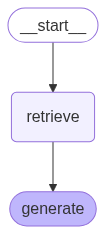

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b45e50a8-1b0b-4ba0-b062-e95e93470d22', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='cd036bdb-454b-4c7e-b24a-e0927a73f12d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

In [17]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='b45e50a8-1b0b-4ba0-b062-e95e93470d22', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='cd036bdb-454b-4c7e-b24a-e0927a73f12d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

In [18]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# Query Analysis

In [19]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [20]:
vector_store = Chroma(
    collection_name="example_collection_v2",
    embedding_function=embeddings,
)
vector_store.add_documents(documents=all_splits)

['eb261647-4509-49d1-b345-b4effb8cc727',
 'fbf1a2c2-9c6d-4d97-aa3c-a5f4ec3e6632',
 'c666b77e-9820-4cd7-b788-190cf5a842d6',
 '2b47d19d-e452-41c7-940c-d37a54d3cdb2',
 'a7f8b2ee-c894-4739-b65d-f07a9bc10475',
 '4d20eca8-515b-407b-b57c-60a6e598a8c2',
 'a35d4cd3-4a61-47d4-b709-5ea4968dd447',
 'c7793d46-7ce1-4e24-a876-37334b85bc80',
 'b096fb87-f972-4171-a594-a0bcbd54be12',
 '4b86cf6c-73d1-41e6-a6b2-dc6392013886',
 '807f913d-d95f-4684-89c8-0bc427842241',
 '7c81d0ec-fbce-4dd9-9dc8-1c455387bb14',
 'a01a8765-52dd-4c50-a8e9-90bc3e98aa2e',
 'a28b22cb-7287-46dd-926d-82e403f62d92',
 '24d1a39d-b4f4-4d86-8fc5-5cb4124694ec',
 '638a3de6-cb32-4484-a952-526142605486',
 '0122970b-1acf-47d0-abfa-dd0e1c465d24',
 '78b71960-ba2e-4675-8261-d49541f75117',
 '7434e3e6-1b59-42d8-b0f2-84d4611581c1',
 '3401b213-ceb2-4d52-a4a3-791fc22cede1',
 '2f915042-380a-421b-a4a7-067bfadc7a0e',
 '91e98634-1432-48ed-a884-d97e2d899cd9',
 '80e4870d-00fc-496d-9ae8-6717cc59905f',
 '165a069e-ea19-4855-8c9c-5fa8c1d4beea',
 'b9528e7a-fcb9-

In [21]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [22]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter={"section": query["section"]},
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [23]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end of the post says about Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='e672796a-08ac-4bca-8d73-42feb6656952', metadata={'section': 'end', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 35126}, page_content='"content": "You will get instructions for code to write.\\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\\nMake sure that every detail of the architecture is, in the end, implemented as code.\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following toke

# Full Code

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# ---------- 分隔線 ----------

# Movie Infos

In [3]:
import json
from langchain.schema import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

with open("Parsing/movie_infos.json", "r", encoding="utf-8") as f:
    movie_infos = json.load(f)

documents = []
for movie_info in movie_infos:
    clean_title = movie_info["Title"].split(". ", 1)[1]
    doc = Document(
        page_content=(
            f"Title: {clean_title}\n\n"
            f"Plot:\n{movie_info['Plot']}\n\n"
            f"Casts and Characters:\n{movie_info['Casts_and_Characters']}"
        ),
        metadata={
            "title": clean_title,
            "plot": movie_info["Plot"],
            "casts_and_characters": movie_info["Casts_and_Characters"],
            "url": movie_info["URL"]
        }
    )
    documents.append(doc)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="movie_infos",
    embedding_function=embeddings,
    persist_directory="./movie_infos_db",
)

vector_store.add_documents(documents)

C:\Users\George\AppData\Local\Temp\ipykernel_29492\3960427352.py:29: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


['4c201471-e4dd-47dc-b9a8-bbcb2bd9285b',
 '93afd42f-b3b3-497e-868f-cc72caace103',
 'b11ee3e3-11ea-4f85-8d9c-17310f55628e',
 'd7afea61-1011-45ec-aaac-a450d709228e',
 '23af263d-ca0b-4fdd-bcf7-4e0eb169d6b3',
 '5a615ac3-b52d-4005-8c24-b5c0764e1ea6',
 '85e53e7b-a15c-4e59-8769-a05a82c5bea7',
 'c4522e6d-6db0-4b4c-b261-17d70d75a90c',
 '1125d8e3-e412-482d-8506-cedb075db186',
 'b60780d5-58ef-4768-ba87-05de591805f1',
 '62c3bb7a-cf0e-468a-b301-7cd792de0099',
 '304cf216-8ae9-4ca0-98d2-8fad28b8f1fd',
 '8aea17cb-dd2e-47a3-a2fd-0d3e2c15d873',
 'c7486f81-3264-4650-9c95-80682ea5d864',
 '26b0ec64-96d2-4527-a378-d369b3a6eb2c',
 '7378ac7c-111d-42cd-90f0-d97cf780530f',
 '496f7812-f657-4536-8b4a-8040ed18a813',
 '7a403e06-4246-4b5c-9136-28fdce9b3282',
 '13983888-4dea-4f17-ae8e-e1e634f16499',
 '97ac8377-f560-4540-ad65-64bb274074ce',
 '9b34bd45-d899-4e00-968f-1d1b9ecb47f5',
 'e4ba1de9-16d7-47fa-a4d0-561120d70cdd',
 '8efec21e-054d-4758-ab5f-f587bd09ee75',
 'ccdedf45-22e5-4224-b689-33ea0f121ff8',
 '50db77fb-39b1-

In [12]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="movie_infos",
    embedding_function=embeddings,
    persist_directory="./movie_infos_db",
)

results = vector_store.similarity_search("I am looking for a movie that a robot pretending to be a human and trying to assassinate the main character. The mvoie is the second installment in a series.", k=5)
for r in results:
    print(f"Title: {r.metadata['title']}")
    print(f"Plot: {r.metadata['plot']}")
    print(f"Casts and Characters: {r.metadata['casts_and_characters']}")
    print()

Title: 機械公敵
Plot: In 2035, a technophobic cop investigates a crime that may have been perpetrated by a robot, which leads to a larger threat to humanity.
Casts and Characters: Will Smith plays Del Spooner
Bridget Moynahan plays Susan Calvin
Bruce Greenwood plays Lawrence Robertson
Alan Tudyk plays Sonny
James Cromwell plays Dr. Alfred Lanning
Adrian Ricard plays Granny, (as Adrian L. Ricard)
Chi McBride plays Lt. John Bergin
Jerry Wasserman plays Baldez
Fiona Hogan plays V.I.K.I.
Peter Shinkoda plays Chin
Terry Chen plays Chin
David Haysom plays NS4 Robot, …
Scott Heindl plays NS4 Robot, …
Sharon Wilkins plays Asthmatic Woman
Craig March plays Detective
Kyanna Cox plays Girl
Darren Moore plays Homeless Man
Aaron Douglas plays USR Attorney #1


Title: 魔鬼終結者2
Plot: A cyborg, identical to the one who failed to kill Sarah Connor, must now protect her ten year old son John from an even more advanced and powerful cyborg.
Casts and Characters: Arnold Schwarzenegger plays The Terminator
Linda 